<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/091_LIME_Model_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/91_LIME_Model_Explainability.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🍋 LIME: Jak otworzyć Czarną Skrzynkę?

Modele takie jak Random Forest czy Sieci Neuronowe to **Black Box**. Wiemy, że działają, ale nie wiemy dlaczego.

LIME opiera się na założeniu: **Każda skomplikowana funkcja jest liniowa, jeśli przybliżymy ją wystarczająco mocno (Lokalnie).**

Ziemia jest okrągła (nieliniowa), ale boisko piłkarskie wydaje się płaskie (liniowe).
LIME buduje "boisko" wokół jednej decyzji modelu i sprawdza, w którą stronę turla się piłka.

**Algorytm:**
1.  Wybierz próbkę $x$.
2.  Wygeneruj sąsiadów $x'$ (szum).
3.  Odpytaj Black Box o wyniki dla sąsiadów $y'$.
4.  Wytrenuj prosty model liniowy na parach $(x', y')$, ważąc je odległością od oryginału.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances

# 1. DANE I MODEL (Black Box)
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

# Trenujemy Las Losowy (Skomplikowany model)
black_box = RandomForestClassifier(n_estimators=100, random_state=42)
black_box.fit(X, y)

print("Czarna Skrzynka gotowa.")

Czarna Skrzynka gotowa.


## Wybór Pacjenta

Wybieramy jednego pacjenta (np. indeks 10), dla którego model przewidział **Brak Raka (Benign)**.
Chcemy wiedzieć: **DLACZEGO?**

In [2]:
idx = 10
patient = X[idx] # Nasz punkt centralny

# Predykcja modelu (Prawdopodobieństwo klasy 1)
# Black Box zwraca [P(0), P(1)]
probs = black_box.predict_proba([patient])[0]

print(f"Pacjent nr {idx}")
print(f"Predykcja modelu: {probs[1]:.4f} (Klasa: {data.target_names[np.argmax(probs)]})")
print("Dlaczego model jest taki pewny? Zapytajmy LIME.")

Pacjent nr 10
Predykcja modelu: 0.1300 (Klasa: malignant)
Dlaczego model jest taki pewny? Zapytajmy LIME.


## Krok 1: Perturbacja (Generowanie Sąsiadów)

Tworzymy 1000 sztucznych pacjentów, którzy są lekko zmodyfikowanymi wersjami naszego oryginału.
Dodajemy szum z rozkładu normalnego.

In [3]:
num_perturbations = 1000
num_features = X.shape[1]

# Generujemy szum (średnia 0, odchylenie na podstawie danych)
# Używamy standardowego odchylenia z całego zbioru, żeby skala szumu miała sens
std_devs = np.std(X, axis=0)
noise = np.random.normal(0, 1, size=(num_perturbations, num_features)) * std_devs

# Tworzymy sąsiadów (Oryginał + Szum)
neighborhood = patient + noise

print(f"Wygenerowano {num_perturbations} sąsiadów.")

Wygenerowano 1000 sąsiadów.


## Krok 2: Etykietowanie i Ważenie

1.  Pytamy **Czarną Skrzynkę** o zdanie dla każdego sąsiada.
2.  Obliczamy **Wagi**: Im sąsiad jest bliżej oryginału, tym jest ważniejszy dla modelu liniowego.
    Używamy jądra wykładniczego: $weight = \exp(-dist^2 / \sigma^2)$.

In [4]:
# 1. Pytamy Las Losowy o zdanie (Etykietowanie)
# Interesuje nas prawdopodobieństwo tej samej klasy co oryginał
target_class = np.argmax(probs)
neighborhood_preds = black_box.predict_proba(neighborhood)[:, target_class]

# 2. Obliczamy odległość od oryginału
distances = pairwise_distances(neighborhood, patient.reshape(1, -1)).ravel()

# 3. Zamieniamy odległość na wagę (Kernel)
# Im bliżej (mniejszy dystans), tym większa waga (bliska 1)
kernel_width = np.sqrt(num_features) * 0.75 
weights = np.sqrt(np.exp(-(distances ** 2) / (kernel_width ** 2)))

print("Dane przygotowane do regresji.")

Dane przygotowane do regresji.


--- WYNIK LIME (Top 10 Cech) ---


,Feature,Weight
13,area error,-0.003141
1,mean texture,-0.001670
20,worst radius,0.001628
23,worst area,0.001628
21,worst texture,0.001046
0,mean radius,0.000511
22,worst perimeter,0.000496
12,perimeter error,0.000383
2,mean perimeter,0.000205
11,texture error,-0.000106


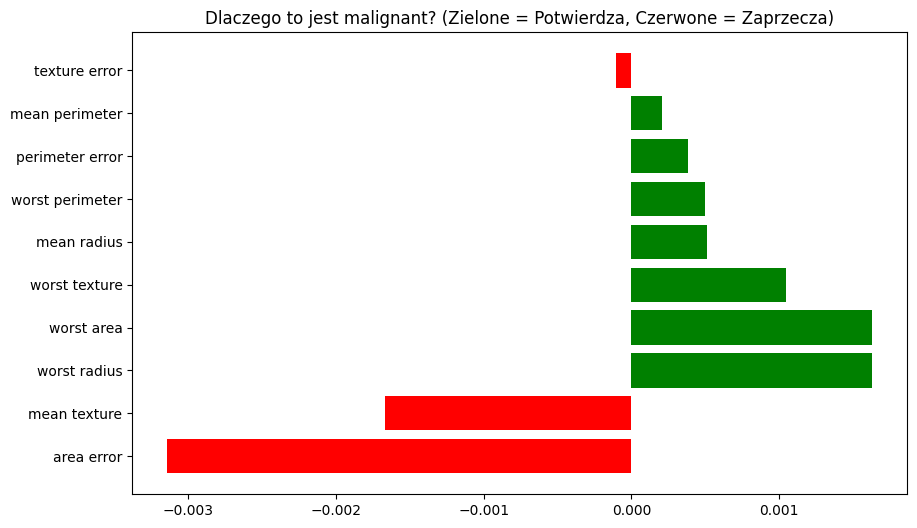

In [5]:
# 3. TRENUJEMY MODEL LINIOWY (Glass Box)
# Uczymy go na szumie, żeby naśladował Las Losowy LOKALNIE
# Ważne: model liniowy musi uwzględnić wagi próbek (sample_weight)

explainer_model = LinearRegression()
explainer_model.fit(neighborhood, neighborhood_preds, sample_weight=weights)

# Wyciągamy współczynniki (To są nasze wyjaśnienia!)
coefficients = explainer_model.coef_

# Sortujemy cechy od najważniejszych
importance = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefficients
}).sort_values(by='Weight', key=abs, ascending=False).head(10)

print("--- WYNIK LIME (Top 10 Cech) ---")
display(importance)

# Wizualizacja
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in importance['Weight']]
plt.barh(importance['Feature'], importance['Weight'], color=colors)
plt.title(f"Dlaczego to jest {data.target_names[target_class]}? (Zielone = Potwierdza, Czerwone = Zaprzecza)")
plt.show()

## 🧠 Podsumowanie: Lokalnie Płaska Ziemia

Co widzisz na wykresie?
Jeśli słupek jest **Zielony**, to znaczy, że wysoka wartość tej cechy zwiększyła pewność modelu, że to nie jest rak.
Jeśli **Czerwony**, to ta cecha sugerowała raka, ale została "przegłosowana" przez inne.

**Dlaczego to działa?**
Las Losowy jest nieliniowy i skomplikowany.
Ale w bardzo małym otoczeniu (wokół jednego pacjenta), jego zachowanie jest proste: *"Trochę więcej promienia -> trochę mniejsza szansa na raka"*.
Regresja Liniowa idealnie wychwytuje ten **lokalny trend**.

To narzędzie jest obowiązkowe w bankach, gdzie musisz wyjaśnić klientowi: *"Odmówiliśmy kredytu, bo masz za krótki staż pracy (Waga: -0.5), mimo że zarabiasz dużo (Waga: +0.2)"*.